In [1]:
import warnings
warnings.filterwarnings('ignore')

# KLIFS pocket

In [2]:
import numpy as np
import pandas as pd
import copy
from itertools import chain

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from mkt.databases import klifs, colors, kinase_schema
from mkt.databases.klifs import KLIFSPocket

## Load data

In [3]:
# files generated in databases.ipynb must be in data directory
dict_kinase = kinase_schema.create_kinase_models_from_df()

dict_klifs = {i: j for i, j in dict_kinase.items() if \
              (j.klifs is not None and j.klifs.pocket_seq is not None)}

In [4]:
# check that all KLIFS2UniProt alignments working as expected - should be no output
for hgnc, pocket in dict_klifs.items():
    list_temp = [pocket.uniprot.canonical_seq[val-1] == pocket.klifs.pocket_seq[idx] \
                 for idx, (key, val) in enumerate(pocket.KLIFS2UniProtIdx.items()) if val is not None]
    not any(list_temp)

## Assess AA conservation of KLIFS pocket

In [5]:
dict_pocket = {key : {idx + 1 : aa for idx, aa in enumerate(val.klifs.pocket_seq)}\
               for key, val in dict_klifs.items()}
df_pocket = pd.DataFrame(dict_pocket).T

In [6]:
df_pocket_melt = pd.melt(df_pocket.reset_index(), id_vars='index')
df_pocket_melt.columns = ["gene_name", "position", "amino_acid"]

In [7]:
df_pocket_pivot = df_pocket_melt.pivot_table(index="amino_acid", columns="position", values="amino_acid", aggfunc="count")
# otherwise numeric
# df_pocket_pivot.columns = [str(col) for col in df_pocket_pivot.columns]
# df_pocket_pivot.loc[df_pocket_pivot.index == "K", 17]

In [8]:
df_pocket_count = pd.DataFrame(df_pocket_melt[["position", "amino_acid"]].value_counts())
df_pocket_count = df_pocket_count.reset_index()

ALPHABET_PROJECT
Invalid single-letter amino acid: -
- is an invalid amino acid; using '-' as default symbol.
ASAP
Invalid single-letter amino acid: -
- is an invalid amino acid; using '-' as default symbol.
RASMOL
Invalid single-letter amino acid: -
- is an invalid amino acid; using '-' as default symbol.
SHAPELY
Invalid single-letter amino acid: -
- is an invalid amino acid; using '-' as default symbol.
CLUSTALX
Invalid single-letter amino acid: -
- is an invalid amino acid; using '-' as default symbol.
ZAPPO
Invalid single-letter amino acid: -
- is an invalid amino acid; using '-' as default symbol.


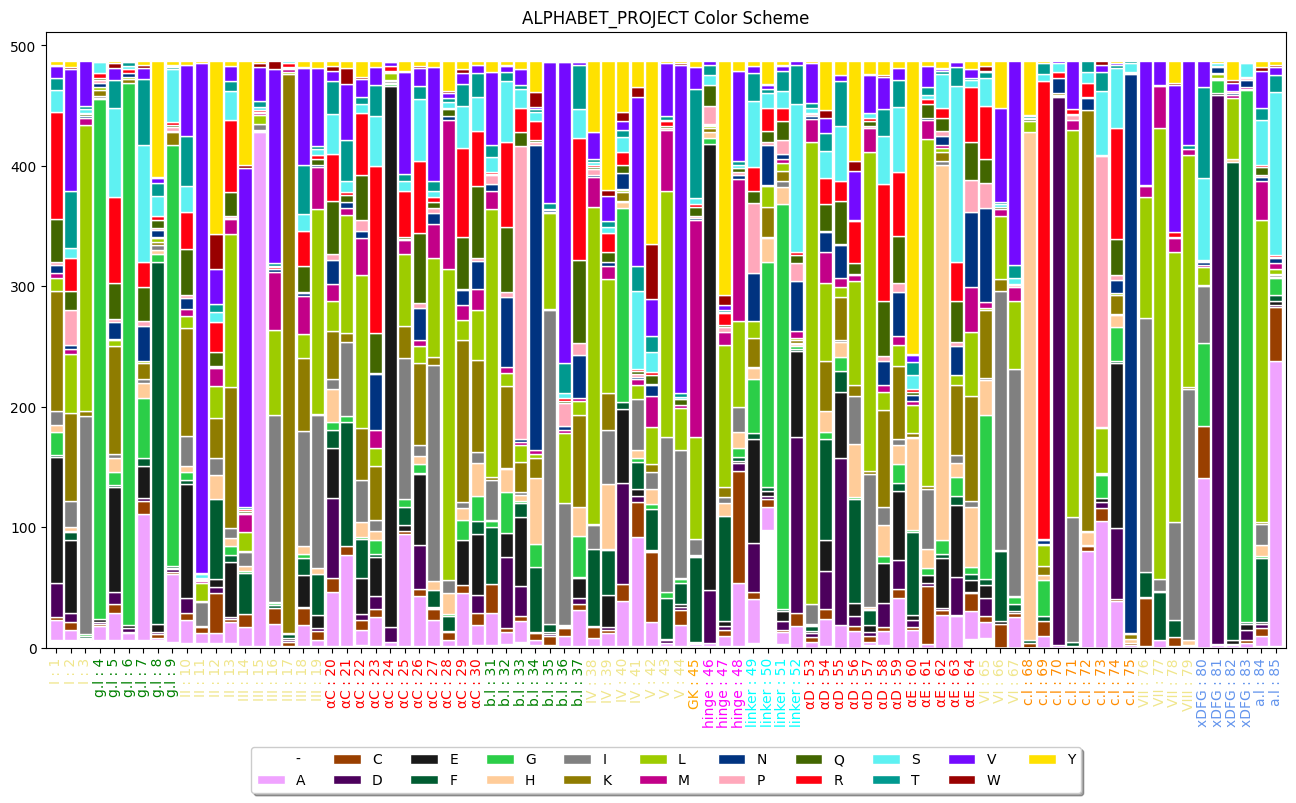

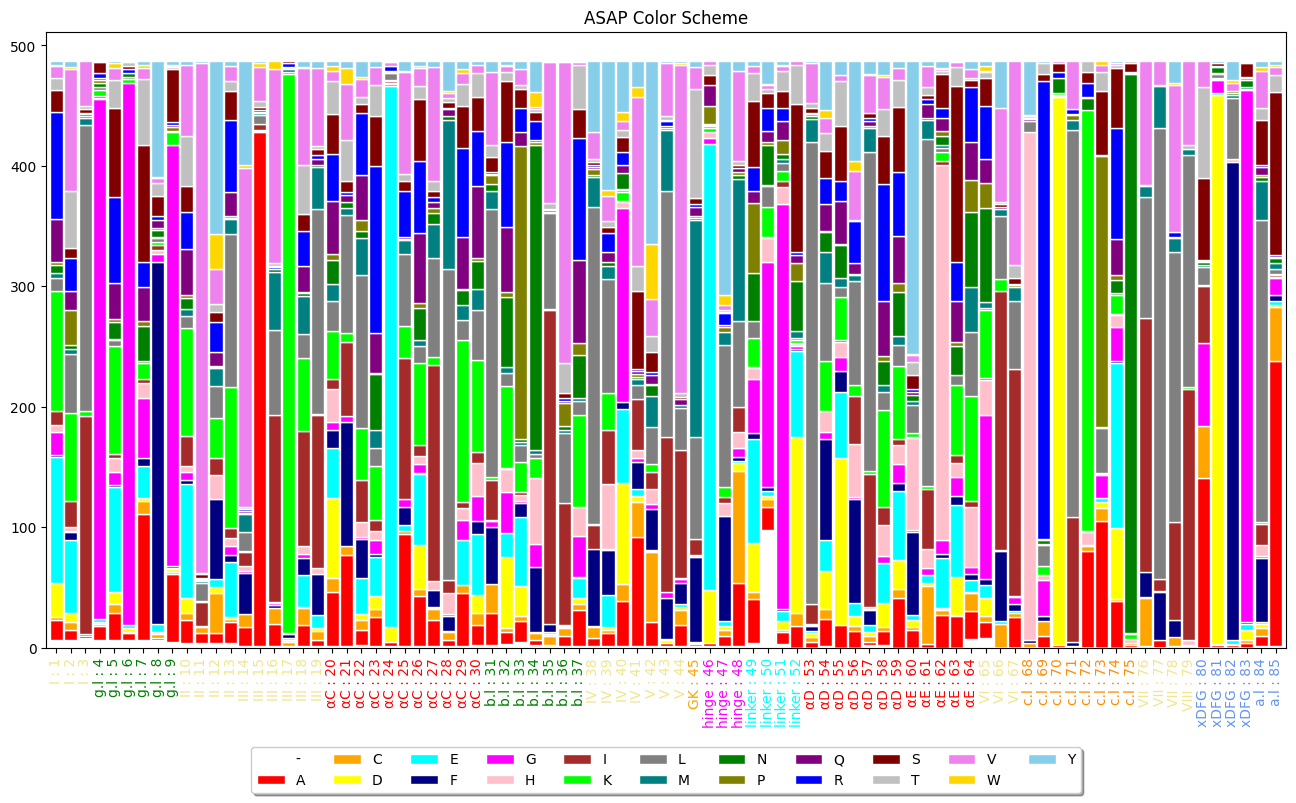

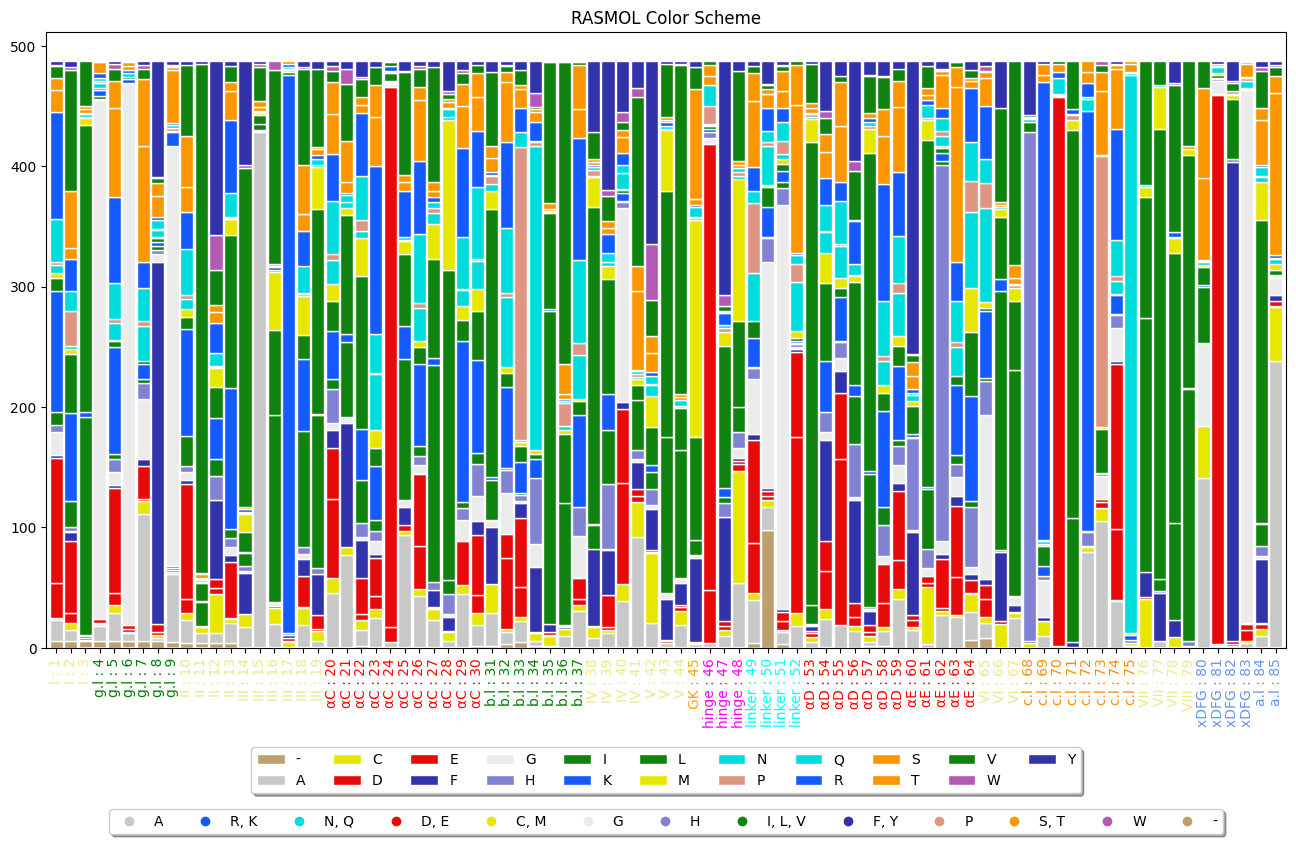

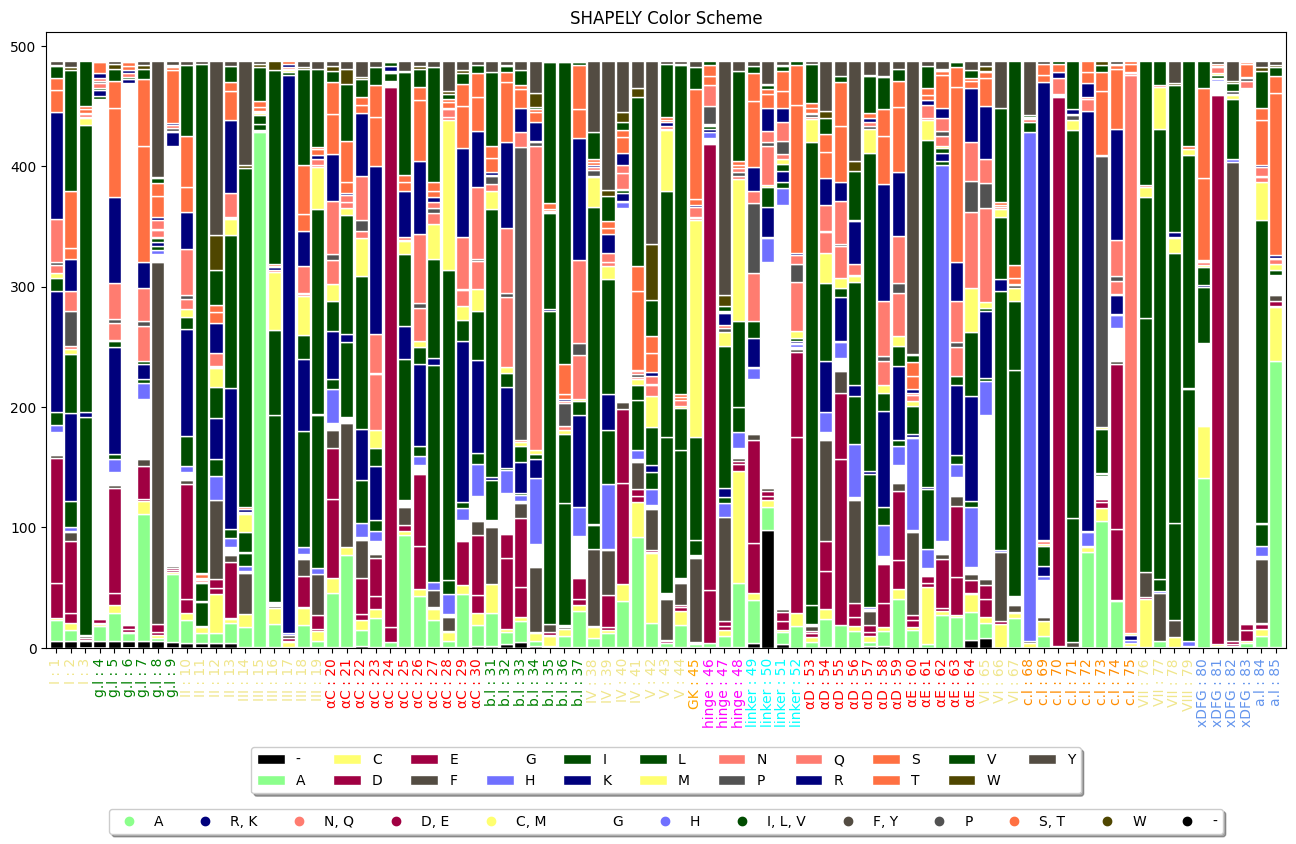

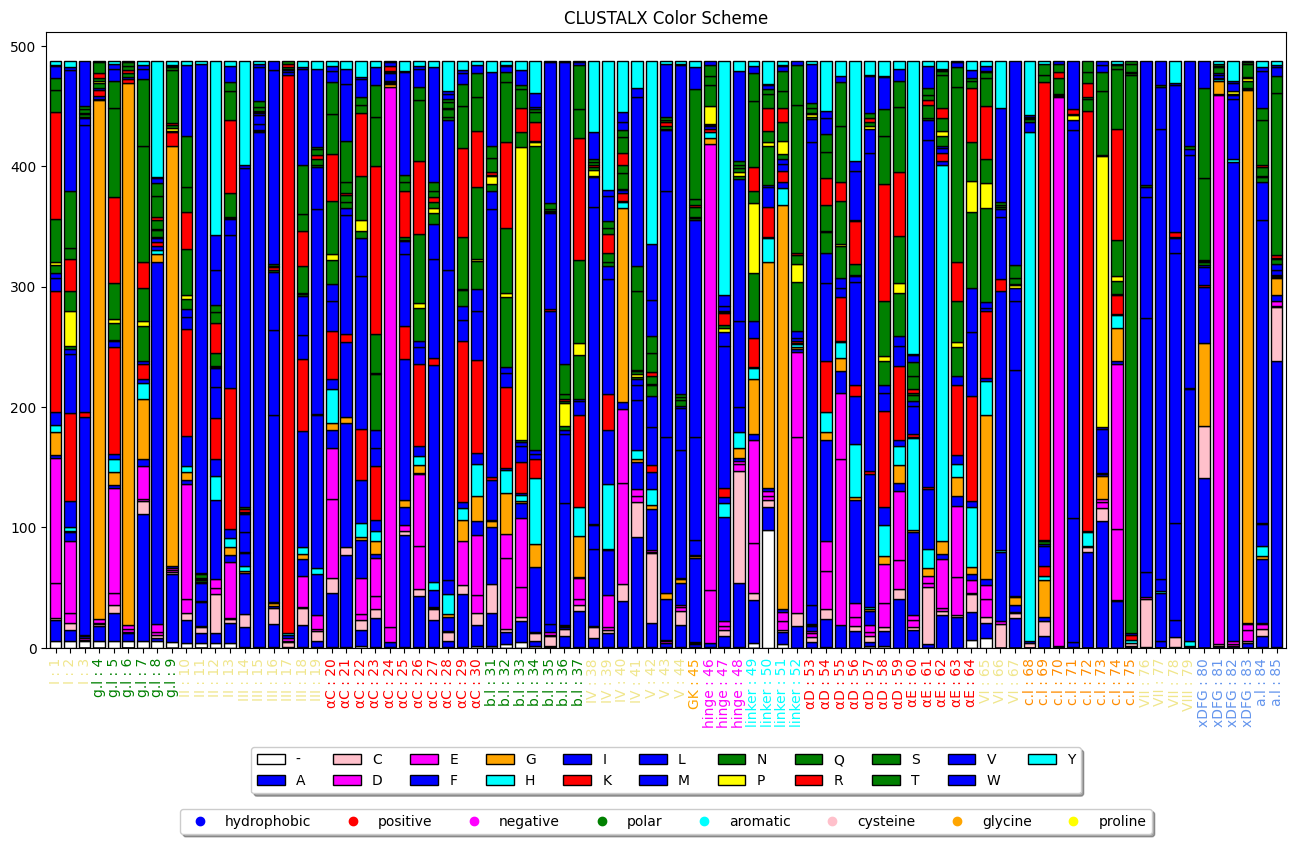

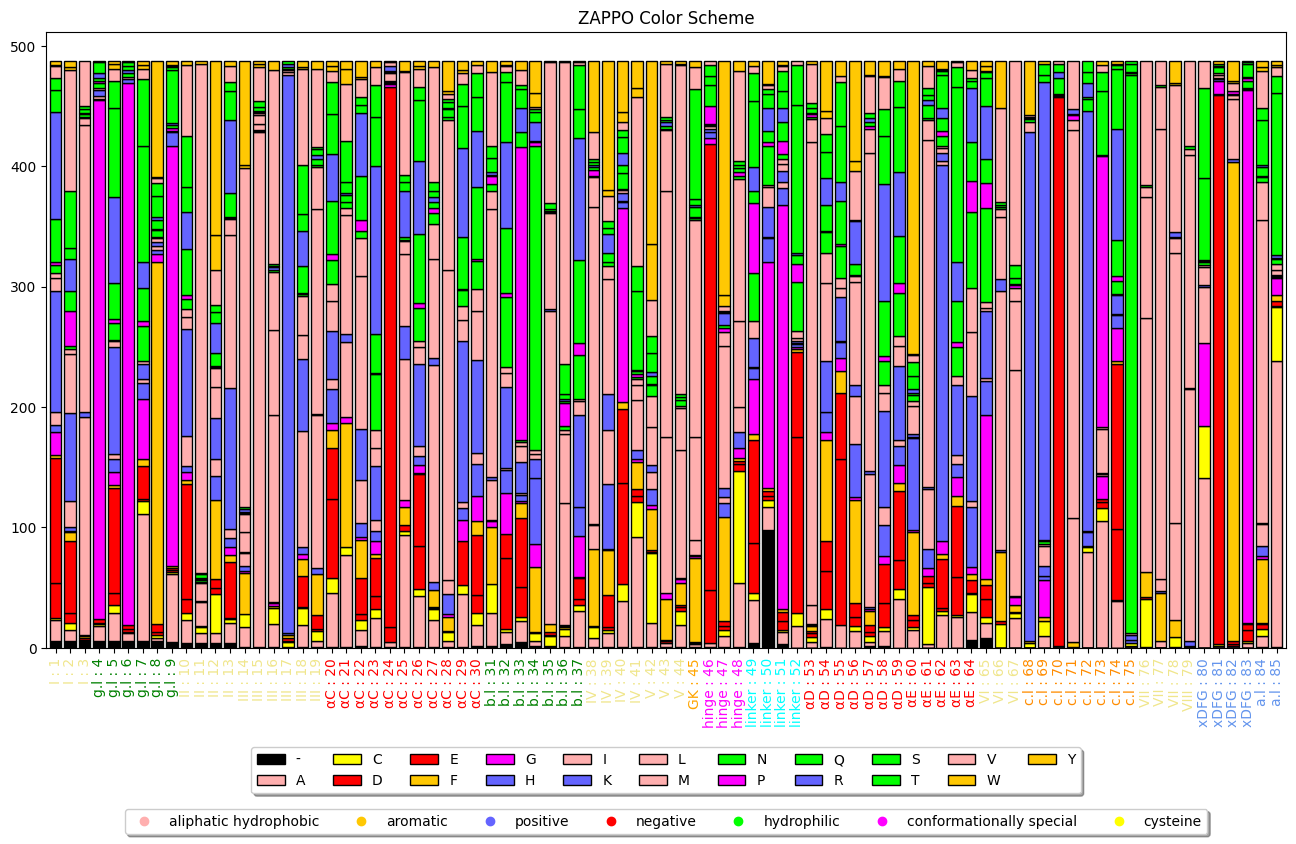

In [9]:
# change x-axis lablel to include KLIFS pocket region
list_cols = [[f"{key} : {i}" for i in range(val["start"], val["end"] + 1)] \
             for key, val in klifs.DICT_POCKET_KLIFS_REGIONS.items()]
list_cols = list(chain.from_iterable(list_cols))
df_pocket_pivot.columns = list_cols

# match x-axis label colors to KLIF pocket region colors
list_axis_col = [[val["color"]] * (val["end"] + 1 - val["start"]) \
                 for _, val in klifs.DICT_POCKET_KLIFS_REGIONS.items()]
list_axis_col = list(chain.from_iterable(list_axis_col))

list_cols = list(colors.DICT_COLORS.keys())
for cols in list_cols:
    print(cols)
    str_col = cols
    dict_col = colors.DICT_COLORS[str_col]["DICT_COLORS"]
    list_fill_col = [colors.map_single_letter_aa_to_color(i, dict_col) \
                     for i in df_pocket_pivot.index.tolist()]
    
    if len(set(list_fill_col)) > 9:
        edgecol = "white"
        colwidth = 0.9
    else:
        edgecol = "black"
        colwidth = 0.8
    
    ax = df_pocket_pivot.T.plot(kind='bar', 
                                stacked=True, 
                                figsize=(16, 8),
                                color=list_fill_col,
                                edgecolor = edgecol, 
                                width = colwidth);
    
    for xtick, color in zip(ax.get_xticklabels(), list_axis_col):
        xtick.set_color(color)
    
    dict_annot = colors.DICT_COLORS[str_col]["DICT_ANNOTATION"]
    if dict_annot is None:
        ax.legend(loc="upper center", 
                  bbox_to_anchor=(0.5, -0.15),
                  fancybox=True, 
                  shadow=True, 
                  ncol=11)
    else:
        l1 = ax.legend(loc="upper center", 
                       bbox_to_anchor=(0.5, -0.15),
                       fancybox=True, 
                       shadow=True, 
                       ncol=11)
        handlelist = [plt.plot([], marker="o", ls="", color=color)[0] for _, color in dict_annot.items()]
        l2 = ax.legend(handlelist,
                       list(dict_annot.keys()),
                       loc="upper center", 
                       bbox_to_anchor=(0.5, -0.25),
                       fancybox=True, 
                       shadow=True, 
                       ncol=len(dict_annot))
        ax.add_artist(l1)
    plt.title(f"{cols} Color Scheme")
    # plt.savefig(f"KLIFS_pocket_{cols}.pdf", bbox_inches="tight");

In [ ]:
import json
import glob

In [24]:
for key, val in dict_kinase.items():
    with open(f"../data/KinaseInfo/{key}.json", "w") as outfile:   
        json.dump(val.json(), outfile)

In [38]:
list_json = glob.glob("../data/KinaseInfo/*")

dict_import = {}

for file in list_json:
    with open(file, "r") as openfile:
        json_obj = json.load(openfile)
        kinase_obj = kinase_schema.KinaseInfo.parse_raw(json_obj)
        dict_import[kinase_obj.hgnc_name] = kinase_obj

dict_import = {key: dict_import[key] for key in sorted(dict_import.keys())}

In [46]:
temp = "PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGKKESSRHGGPHCNVFVEHEALQRPVASDFEPQGLSEAARWNSKENLLAGPSENDPNLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVNSLEKHSWYHGPVSRNAAEYLLSSGINGSFLVRESESSPGQRSISLRYEGRVYHYRINTASDGKLYVSSESRFNTLAELVHHHSTVADGLITTLHYPAPKRNKPTVYGVSPNYDKWEMERTDITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVNAVVLLYMATQISSAMEYLEKKNFIHRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKSDVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNPSDRPSFAEIHQAFETMFQESSISDEVEKELGKQGVRGAVSTLLQAPELPTKTRTSRRAAEHRDTTDVPEMPHSKGQGESDPLDHEPAVSPLLPRKERGPPEGGLNEDERLLPKDKKTNLFSALIKKKKKTAPTPPKRSSSFREMDGQPERRGAGEEEGRDISNGALAFTPLDTADPAKSPKPSNGAGVPNGALRESGGSGFRSPHLWKKSSTLTSSRLATGEEEGGGSSSKRFLRSCSASCVPHGAKDTEWRSVTLPRDLQSTGRQFDSSTFGGHKSEKPALPRKRAGENRSDQVTRGTVTPPPRLVKKNEEAADEVFKDIMESSPGSSPPNLTPKPLRRQVTVAPASGLPHKEEAGKGSALGTPAAAEPVTPTSKAGSGAPGGTSKGPAEESRVRRHKHSSESPGRDKGKLSRLKPAPPPPPAASAGKAGGKPSQSPSQEAAGEAVLGAKTKATSLVDAVNSDAAKPSQPGEGLKKPVLPATPKPQSAKPSGTPISPAPVPSTLPSASSALAGDQPSSTAFIPLISTRVSLRKTRQPPERIASGAITKGVVLDSTEALCLAISRNSEQMASHSAVLEAGKNLYTFCVSYVDSIQQMRNKFAFREAINKLENNLRELQICPATAGSGPAATQDFSKLLSSVKEISDIVQR"

In [48]:
len(temp)

1167

In [49]:
len(dict_kinase["ABL1"].UniProt.canonical_seq)

1130

In [50]:
dict_kinase["ABL1"].UniProt.canonical_seq in temp

False

In [43]:
"VKEISDIVQ" in dict_kinase["ABL1"].UniProt.canonical_seq

True